Importing / Downloading

In [ ]:
# General libs for file paths, data extraction, etc
from glob import glob
from pathlib import Path
from os.path import basename
import zipfile # To extract zipfiles
import urllib3 
urllib3.disable_warnings() # Disable warnings for data download via API

# CDS API
import cdsapi

# Libraries for working with multi-dimensional arrays
import numpy as np
import xarray as xr
import pandas as pd

# Libraries for plotting and visualising data
import matplotlib.path as mpath
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature

In [ ]:
DATADIR = '../data/cds'

In [ ]:
models = ['hadgem3_gc31_ll', 'inm_cm5_0', 'inm_cm4_8', 'ipsl_cm6a_lr', 
          'miroc_es2l', 'mpi_esm1_2_lr', 'ukesm1_0_ll']
c = cdsapi.Client()
for j in models: 
        c.retrieve(
                'projections-cmip6',
                {
                        'format': 'zip', 
                        'temporal_resolution': 'monthly',
                        'experiment': 'historical',
                        'variable': ['near_surface_air_temperature'],
                        'model': f'{j}',
                },
                f'{DATADIR}cmip6_monthly_1850-2014_historical_{j}.zip'
                )
    

In [ ]:
DATADIR = '../data/cds'
experiments = ['historical', 'ssp126', 'ssp245', 'ssp585']
models = ['hadgem3_gc31_ll', 'inm_cm5_0', 'inm_cm4_8', 'ipsl_cm6a_lr', 
          'miroc_es2l', 'mpi_esm1_2_lr', 'ukesm1_0_ll']

c = cdsapi.Client()
for i in experiments[1:]:
        for j in models: 
                c.retrieve(
                        'projections-cmip6',
                        {
                                'format': 'zip', 
                                'data_format': 'netcdf_legacy',
                                'temporal_resolution': 'monthly',
                                'experiment': f'{i}',
                                'variable': ['near_surface_air_temperature'],
                                'model': f'{j}',
                        },
                        f'{DATADIR}cmip6_monthly_2015-2100_{i}_{j}.zip')
    

In [ ]:
cmip6_zip_paths = glob(f'{DATADIR}*.zip')
for j in cmip6_zip_paths:
    with zipfile.ZipFile(j, 'r') as zip_ref:
        zip_ref.extractall(f'{DATADIR}')

Aggregating

In [55]:
import os

cmip6_nc = list()
cmip6_nc_rel = glob('../data/cds/tas*.nc')
for i in cmip6_nc_rel:
    cmip6_nc.append(os.path.basename(i))

In [56]:
cmip6_nc[0:5]


['tas_Amon_HadGEM3-GC31-LL_historical_r1i1p1f3_gn_185001-194912.nc',
 'tas_Amon_INM-CM5-0_ssp245_r1i1p1f1_gr1_201501-210012.nc',
 'tas_Amon_MPI-ESM1-2-LR_ssp126_r1i1p1f1_gn_203501-205412.nc',
 'tas_Amon_HadGEM3-GC31-LL_historical_r1i1p1f3_gn_195001-201412.nc',
 'tas_Amon_HadGEM3-GC31-LL_ssp126_r1i1p1f3_gn_201501-204912.nc']

In [57]:
ds = xr.open_dataset(f'../data/cds/{cmip6_nc[0]}', engine='netcdf4')
ds

<xarray.Dataset> Size: 133MB
Dimensions:    (time: 1200, bnds: 2, lat: 144, lon: 192)
Coordinates:
  * time       (time) object 10kB 1850-01-16 00:00:00 ... 1949-12-16 00:00:00
  * lat        (lat) float64 1kB -89.38 -88.12 -86.88 ... 86.88 88.12 89.38
  * lon        (lon) float64 2kB 0.9375 2.812 4.688 6.562 ... 355.3 357.2 359.1
    height     float64 8B ...
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) object 19kB ...
    lat_bnds   (lat, bnds) float64 2kB ...
    lon_bnds   (lon, bnds) float64 3kB ...
    tas        (time, lat, lon) float32 133MB ...
Attributes: (12/46)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   0.0
    branch_time_in_parent:  0.0
    creation_date:          2019-06-19T11:21:17Z
    ...                     ...
    title:                  HadGEM3-GC31-LL output prepared for CMIP6
    variable_id:            tas
    variant_label:          r1i1p1f3
    license:                CMIP6 model data produced by the Met Office Hadle...
    cmor_version:           3.4.0
    tracking_id:            hdl:21.14100/b6959414-d5ed-4cd9-a627-59238e52132d

In [58]:
exp = ds.attrs['experiment_id']
mod = ds.attrs['source_id']

In [59]:
da = ds['tas']

In [60]:
weights = np.cos(np.deg2rad(da.lat))
weights.name = "weights"
da_weighted = da.weighted(weights)

In [61]:
da_agg = da_weighted.mean(['lat', 'lon'])

In [62]:
da_yr = da_agg.groupby('time.year').mean()

In [63]:
da_yr = da_yr - 273.15

In [64]:
da_yr = da_yr.assign_coords(model=mod)
da_yr = da_yr.expand_dims('model')
da_yr = da_yr.assign_coords(experiment=exp)
da_yr = da_yr.expand_dims('experiment')

In [65]:
da_yr

<xarray.DataArray 'tas' (experiment: 1, model: 1, year: 100)> Size: 800B
array([[[13.57671526, 13.61972281, 13.69983418, 13.58121524,
         13.42119522, 13.65739828, 13.76131597, 13.73791802,
         13.65716427, 13.67835953, 13.6958831 , 13.62055952,
         13.55175635, 13.61000565, 13.73843491, 13.82236892,
         13.81097131, 13.71154059, 13.56211982, 13.59462567,
         13.69838333, 13.71297368, 13.626492  , 13.47792634,
         13.44426972, 13.57834863, 13.64239096, 13.5923281 ,
         13.58969398, 13.59995504, 13.6784006 , 13.58594713,
         13.52578675, 13.55900851, 13.33312269, 13.34003796,
         13.44220428, 13.4684809 , 13.532143  , 13.52096238,
         13.56463006, 13.60706616, 13.45990259, 13.52832378,
         13.63428028, 13.5034919 , 13.63096095, 13.6718442 ,
         13.59183465, 13.59545236, 13.57329724, 13.60939761,
         13.47178509, 13.30891415, 13.49458141, 13.45830435,
         13.49019517, 13.5930144 , 13.43560995, 13.26435911,
         13.28967819, 13.43989207, 13.37834352, 13.49492732,
         13.58852128, 13.55871324, 13.50181185, 13.52223888,
         13.61381449, 13.74087832, 13.6619678 , 13.63366253,
         13.61540165, 13.7149855 , 13.74137372, 13.64107948,
         13.70797182, 13.64631935, 13.73509469, 13.65373661,
         13.50726181, 13.442404  , 13.51578823, 13.49988313,
         13.58586453, 13.72074743, 13.50039503, 13.5595421 ,
         13.67134228, 13.68391298, 13.72435359, 13.84893734,
         13.6550208 , 13.49563556, 13.57712205, 13.51146538,
         13.63706029, 13.69014757, 13.59581395, 13.73335949]]])
Coordinates:
    height      float64 8B 1.5
  * year        (year) int64 800B 1850 1851 1852 1853 ... 1946 1947 1948 1949
  * model       (model) <U15 60B 'HadGEM3-GC31-LL'
  * experiment  (experiment) <U10 40B 'historical'

In [66]:
def geog_agg(fn):
    """
    Opens a CMIP6 file, does a global weighted mean, 
    and saves the result to a new file.
    Assumes coords: time, lat, lon; data var: 'tas'.
    """
    ds = xr.open_dataset(
        os.path.join('../data/cds/', fn),
        decode_times=True,
        use_cftime=True  # needed if times are outside normal Python datetime range
    )

    if "height" in ds.variables:
        ds = ds.drop_vars("height")

    exp = ds.attrs['experiment_id']
    mod = ds.attrs['source_id']
    da = ds['tas']
    
    weights = np.cos(np.deg2rad(da.lat))
    da_weighted = da.weighted(weights)
    da_agg = da_weighted.mean(['lat','lon'])
    da_yr = da_agg.groupby('time.year').mean() - 273.15
    
   # Add dimensions for model and experiment
    da_yr = da_yr.assign_coords(model=mod).expand_dims('model')
    da_yr = da_yr.assign_coords(experiment=exp).expand_dims('experiment')

    # Name the DataArray so Xarray can merge it correctly
    da_yr.name = "tas"
    ds_out = da_yr.to_dataset(name="tas")
    ds_out.to_netcdf(f'../data/cds/cmip6_agg_{exp}_{mod}_{da_yr.year[0].values}.nc')

# Then in your loop:
from glob import glob

cmip6_nc_rel = glob('../data/cds/tas*.nc')
cmip6_nc = [os.path.basename(i) for i in cmip6_nc_rel]

for i in cmip6_nc:
    try:
        geog_agg(i)
    except Exception as e:
        print(f"{i} failed: {e}")

/var/folders/2l/6514_hd91tv5448lmq79vpbw0000gn/T/ipykernel_23909/2469485114.py:7: DeprecationWarning: Usage of 'use_cftime' as a kwarg is deprecated. Please pass a 'CFDatetimeCoder' instance initialized with 'use_cftime' to the 'decode_times' kwarg instead.
Example usage:
    time_coder = xr.coders.CFDatetimeCoder(use_cftime=True)
    ds = xr.open_dataset(decode_times=time_coder)

  ds = xr.open_dataset(
/var/folders/2l/6514_hd91tv5448lmq79vpbw0000gn/T/ipykernel_23909/2469485114.py:7: DeprecationWarning: Usage of 'use_cftime' as a kwarg is deprecated. Please pass a 'CFDatetimeCoder' instance initialized with 'use_cftime' to the 'decode_times' kwarg instead.
Example usage:
    time_coder = xr.coders.CFDatetimeCoder(use_cftime=True)
    ds = xr.open_dataset(decode_times=time_coder)

  ds = xr.open_dataset(
/var/folders/2l/6514_hd91tv5448lmq79vpbw0000gn/T/ipykernel_23909/2469485114.py:7: DeprecationWarning: Usage of 'use_cftime' as a kwarg is deprecated. Please pass a 'CFDatetimeCoder' in

In [69]:
# data_ds = xr.open_mfdataset('../data/cds/cmip6_agg*.nc')
data_ds = xr.open_mfdataset('../data/cds/cmip6_agg*.nc', combine='by_coords')


In [70]:
data_ds.load()

<xarray.Dataset> Size: 105kB
Dimensions:     (experiment: 4, model: 7, year: 451)
Coordinates:
  * year        (year) int64 4kB 1850 1851 1852 1853 ... 2297 2298 2299 2300
  * model       (model) <U15 420B 'HadGEM3-GC31-LL' ... 'UKESM1-0-LL'
  * experiment  (experiment) <U10 160B 'historical' 'ssp126' 'ssp245' 'ssp585'
Data variables:
    tas         (experiment, model, year) float64 101kB 13.58 13.62 ... nan nan

In [71]:
data = data_ds['tas']

In [72]:
data_90 = data.quantile(0.9, dim='model')
data_10 = data.quantile(0.1, dim='model')
data_50 = data.quantile(0.5, dim='model')

/Users/lukaskreibig/Documents/climate-dashboard/.venv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,


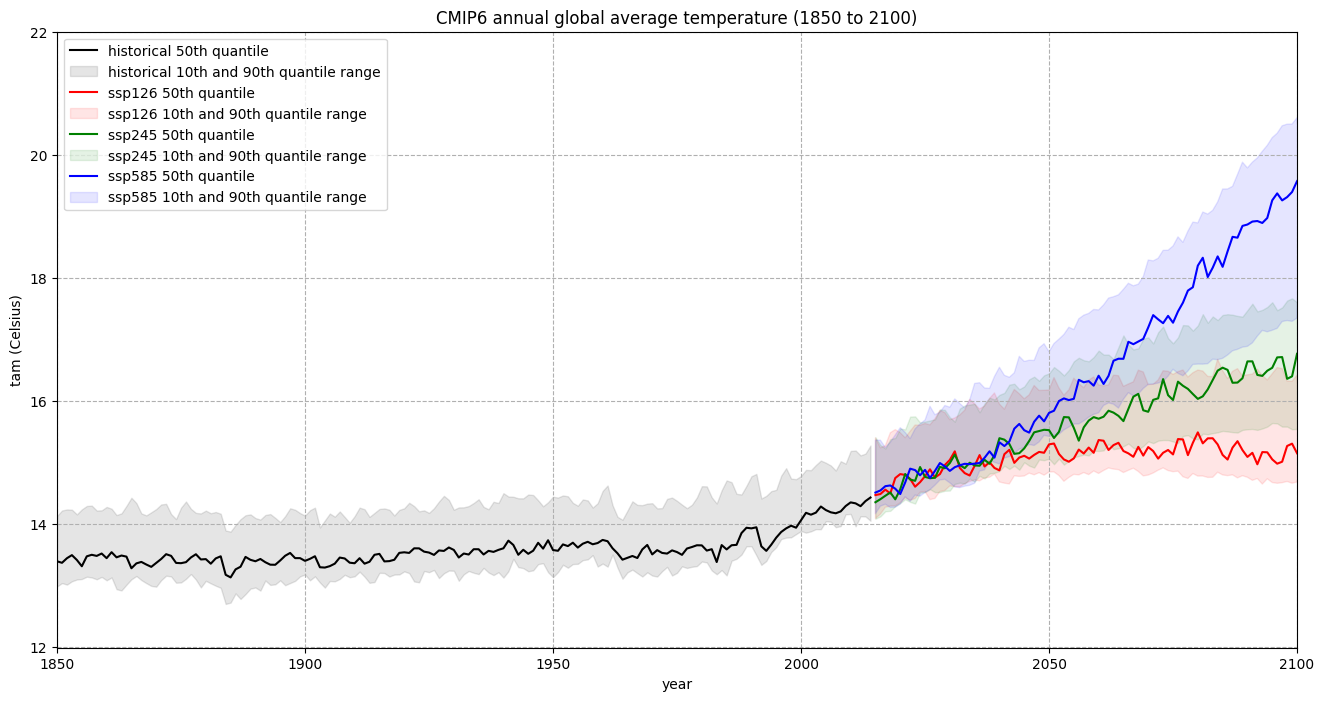

In [73]:
experiments = data_50.experiment.values.tolist()

fig, ax = plt.subplots(1, 1, figsize = (16, 8))

colours = ['black','red','green','blue']
for i in np.arange(len(experiments)):
    ax.plot(data_50.year, data_50[i,:], color=f'{colours[i]}', 
            label=f'{data_50.experiment[i].values} 50th quantile')
    ax.fill_between(data_50.year, data_90[i,:], data_10[i,:], alpha=0.1, color=f'{colours[i]}', 
            label=f'{data_50.experiment[i].values} 10th and 90th quantile range')

ax.set_xlim(1850,2100)
ax.set_title('CMIP6 annual global average temperature (1850 to 2100)')
ax.set_ylabel('tam (Celsius)')
ax.set_xlabel('year')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, loc='upper left')
ax.set_ylim(None, 22)
ax.grid(linestyle='--')
fig.savefig(f'{DATADIR}CMIP6_annual_global_tas.png')

In [ ]:
# 1) Compute multi-model mean:
ensemble_tas = data.mean(dim='model')  # dims: (experiment, year)

# 2) Save to a NetCDF so other notebooks can load it:
ensemble_tas.name = 'tas'
ensemble_tas.to_dataset().to_netcdf('../data/cds/cmip6_ensemble_mean.nc')

In [74]:
# After loading your multi-file dataset
data = data_ds['tas']

# Check for NaNs per coordinate (this returns a DataArray with counts)
nan_counts = data.isnull().sum()
print("NaN counts by dimension:\n", nan_counts)

# Check the total number of NaNs in the entire data array
total_nans = int(data.isnull().sum().item())
print("Total number of NaNs:", total_nans)

if total_nans > 0:
    print("Warning: There are missing values in the dataset.")
else:
    print("No missing values found in the dataset.")


NaN counts by dimension:
 <xarray.DataArray 'tas' ()> Size: 8B
array(9267)
Total number of NaNs: 9267


In [17]:
import os
import xarray as xr
import numpy as np
import pandas as pd
from glob import glob

########################################
# 1) AGGREGATE MONTHLY GLOBAL MEANS
#    (decode_times=False to avoid mixing calendars now)
########################################

def geog_agg_monthly(fn):
    """
    1. Opens a CMIP6 netCDF file (monthly 'tas') with decode_times=False,
       so we get numeric time (no conflicting calendars).
    2. Does a global weighted mean over lat/lon for each monthly time step,
    3. Subtracts 273.15 to convert Kelvin => °C,
    4. Saves the aggregator file: cmip6_agg_monthly_{experiment}_{model}.nc
       with dims: (time, experiment, model) but time is numeric.
    """
    ds = xr.open_dataset(
        os.path.join('../data/cds', fn),
        decode_times=False
    )
    if "height" in ds.variables:
        ds = ds.drop_vars("height")

    exp = ds.attrs.get('experiment_id', 'unknown_exp')
    mod = ds.attrs.get('source_id', 'unknown_mod')

    da = ds["tas"]
    # Weighted mean over lat/lon
    da_c = da - 273.15
    weights = np.cos(np.deg2rad(da_c.lat))
    da_weighted = da_c.weighted(weights)
    da_monthly = da_weighted.mean(dim=["lat","lon"])  # dims: time

    # Add coords
    da_monthly = da_monthly.assign_coords(model=mod).expand_dims("model")
    da_monthly = da_monthly.assign_coords(experiment=exp).expand_dims("experiment")
    da_monthly.name = "tas"

    out_fn = f'../data/cds/cmip6_agg_monthly_{exp}_{mod}.nc'
    if os.path.exists(out_fn):
        os.remove(out_fn)
    da_monthly.to_dataset(name="tas").to_netcdf(out_fn)
    print(f"Aggregator saved: {out_fn}")


########################################
# 2) RUN THE AGGREGATOR ON ALL .nc FILES
########################################

nc_files = glob('../data/cds/tas*.nc')
for ncfile in nc_files:
    try:
        geog_agg_monthly(os.path.basename(ncfile))
    except Exception as e:
        print(f"Aggregation failed for {ncfile}: {e}")


########################################
# 3) OPEN MULTI-FILE DATASET (numeric time), THEN DECODE CF
########################################

agg_files = glob('../data/cds/cmip6_agg_monthly_*.nc')
ds_agg = xr.open_mfdataset(
    agg_files,
    combine='by_coords',
    decode_times=False
)
ds_agg.load()
print("Opened aggregator dataset with numeric time:\n", ds_agg)

# decode all calendars as CFTime
ds_decoded = xr.decode_cf(ds_agg, use_cftime=True)
print("Decoded CFTime across aggregator files:\n", ds_decoded)


########################################
# 4) COMPUTE ENSEMBLE MEAN ACROSS MODELS
########################################

data = ds_decoded["tas"]  # dims: (experiment, model, time)
ensemble_tas = data.mean(dim="model")  # dims: (experiment, time)
ensemble_tas.name = "tas"

ens_file = '../data/cds/cmip6_ensemble_mean_monthly.nc'
if os.path.exists(ens_file):
    os.remove(ens_file)
ensemble_tas.to_dataset(name="tas").to_netcdf(ens_file)
print("Saved monthly ensemble mean:", ens_file)


########################################
# 5) SPLICE HISTORICAL + SCENARIO, 
#    CONVERT cftime TO DATE STRINGS, 
#    EXPORT TO CSV
########################################

def cftime_to_monthly_string(cf_time):
    """
    Convert a cftime object to a 'YYYY-MM' string.
    We'll assume day ~ mid-month = 15 for clarity.
    If you prefer 'YYYY-MM-DD', do something like:
      return f"{cf_time.year:04d}-{cf_time.month:02d}-{cf_time.day:02d}"
    """
    year = cf_time.year
    month = cf_time.month
    # e.g. pick day=15
    return f"{year:04d}-{month:02d}-15"

def splice_historical_scenario_monthly(da, scenario="ssp126"):
    """
    da: xarray DataArray with dims: (experiment, time) => monthly cftime
    scenario: 'ssp126','ssp245','ssp585'

    Returns a DataFrame with columns [ds, tas]:
      - ds is a string date 'YYYY-MM-15' 
      - tas is monthly ensemble mean °C
      spanning 1850..2014 for 'historical' + 2015..2100 for scenario
    """
    # Slice historical portion
    da_hist = da.sel(experiment='historical').sel(time=slice("1850","2014"))  # monthly
    # Slice scenario portion
    da_scen = da.sel(experiment=scenario).sel(time=slice("2015","2100"))

    da_comb = xr.concat([da_hist, da_scen], dim="time")

    # to DataFrame
    df = da_comb.to_dataframe(name="tas").reset_index()  # columns: ['time','tas','experiment']
    df = df[["time","tas"]].sort_values("time").reset_index(drop=True)

    # convert each CFTime to string
    df["ds"] = df["time"].apply(cftime_to_monthly_string)
    df = df[["ds","tas"]]
    return df

ds_ens = xr.open_dataset('../data/cds/cmip6_ensemble_mean_monthly.nc', decode_times=True, use_cftime=True)
da_ens = ds_ens["tas"]

df_126 = splice_historical_scenario_monthly(da_ens, "ssp126")
df_245 = splice_historical_scenario_monthly(da_ens, "ssp245")
df_585 = splice_historical_scenario_monthly(da_ens, "ssp585")

df_126.to_csv("../data/cds/tas_ensemble_ssp126_monthly_1850_2100.csv", index=False)
df_245.to_csv("../data/cds/tas_ensemble_ssp245_monthly_1850_2100.csv", index=False)
df_585.to_csv("../data/cds/tas_ensemble_ssp585_monthly_1850_2100.csv", index=False)

print("\nCreated CSVs with 'ds' as 'YYYY-MM-15' strings, each record = monthly data from 1850..2100.")
print("All done!")


Aggregator saved: ../data/cds/cmip6_agg_monthly_historical_HadGEM3-GC31-LL.nc
Aggregator saved: ../data/cds/cmip6_agg_monthly_ssp245_INM-CM5-0.nc
Aggregator saved: ../data/cds/cmip6_agg_monthly_ssp126_MPI-ESM1-2-LR.nc
Aggregator saved: ../data/cds/cmip6_agg_monthly_historical_HadGEM3-GC31-LL.nc
Aggregator saved: ../data/cds/cmip6_agg_monthly_ssp126_HadGEM3-GC31-LL.nc
Aggregator saved: ../data/cds/cmip6_agg_monthly_historical_MPI-ESM1-2-LR.nc
Aggregator saved: ../data/cds/cmip6_agg_monthly_ssp126_UKESM1-0-LL.nc
Aggregator saved: ../data/cds/cmip6_agg_monthly_ssp126_MPI-ESM1-2-LR.nc
Aggregator saved: ../data/cds/cmip6_agg_monthly_historical_INM-CM4-8.nc
Aggregator saved: ../data/cds/cmip6_agg_monthly_ssp585_MPI-ESM1-2-LR.nc
Aggregator saved: ../data/cds/cmip6_agg_monthly_ssp585_MPI-ESM1-2-LR.nc
Aggregator saved: ../data/cds/cmip6_agg_monthly_ssp245_IPSL-CM6A-LR.nc
Aggregator saved: ../data/cds/cmip6_agg_monthly_ssp245_UKESM1-0-LL.nc
Aggregator saved: ../data/cds/cmip6_agg_monthly_ssp585_

/var/folders/2l/6514_hd91tv5448lmq79vpbw0000gn/T/ipykernel_26101/22887559.py:76: DeprecationWarning: Usage of 'use_cftime' as a kwarg is deprecated. Please pass a 'CFDatetimeCoder' instance initialized with 'use_cftime' to the 'decode_times' kwarg instead.
Example usage:
    time_coder = xr.coders.CFDatetimeCoder(use_cftime=True)
    ds = xr.open_dataset(decode_times=time_coder)

  ds_decoded = xr.decode_cf(ds_agg, use_cftime=True)
/var/folders/2l/6514_hd91tv5448lmq79vpbw0000gn/T/ipykernel_26101/22887559.py:139: DeprecationWarning: Usage of 'use_cftime' as a kwarg is deprecated. Please pass a 'CFDatetimeCoder' instance initialized with 'use_cftime' to the 'decode_times' kwarg instead.
Example usage:
    time_coder = xr.coders.CFDatetimeCoder(use_cftime=True)
    ds = xr.open_dataset(decode_times=time_coder)

  ds_ens = xr.open_dataset('../data/cds/cmip6_ensemble_mean_monthly.nc', decode_times=True, use_cftime=True)


AttributeError: 'float' object has no attribute 'year'